In [227]:
# Basic Imports
import os
import pandas as pd
import numpy as np
import itertools
import csv
from pandas import Series, date_range

# SVM-specific imports
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

# Neural network-specific imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

# Imports for evaluation and visualisation
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [65]:
def load_data(filepath):
    return pd.read_parquet(filepath)

In [66]:
def save_parameters_to_csv(params, file_path):
    with open(file_path, "w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=params.keys())
        writer.writeheader()
        writer.writerow(params)
    print(f'Parameters successfully saved to {file_path}' )

In [67]:
def save_metrics_to_csv(metrics, file_path):
    with open(file_path, "w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=metrics.keys())
        writer.writeheader()
        writer.writerow(metrics)
    print(f'Metrics saved to {file_path}')

In [68]:
# Extract necessary features for model input
def create_features(df):
    df['week'] = df['trip_start_timestamp'].dt.isocalendar().week
    df['2_hour_window'] = df['trip_start_timestamp'].dt.floor('2h').dt.hour
    return df

In [69]:
def prepare_weather_metrics(df):
    df['Temperature'] = df['Temperature'].str.extract('(\d+)').astype(float)
    df['Wind Speed'] = pd.to_numeric(df['Wind Speed'].str.extract('(\d+)')[0], errors='coerce')
    df['Humidity'] = df['Humidity'].str.replace(r'[^\d%]', '', regex=True).str.replace('%', '').astype(float) / 100
    df['Precip.'] = df['Precip.'].replace('Trace', 0).replace(r'[^\d.]', '', regex=True).astype(float)
    return df

In [124]:
def create_prediction_dataset(df, temporal_res, spatial_res):
    # Define time window based on temporal resolution
    time_window_col = f'{temporal_res}_hour_window' if temporal_res < 24 else 'weekday'

    if spatial_res == 'census':
        df = df.dropna(subset=['pickup_census_tract'])
        pickup_column = f'pickup_census_tract'
        spatial_print = 'census_tract'
    else:
        pickup_column = f'h3_res{spatial_res}_pickup'
        spatial_print = f'h3_res_{spatial_res}'

    grouping_columns = [pickup_column, 'week', time_window_col]

    aggregations = {
        'Temperature': 'mean',
        'Humidity': 'mean',
        'Precip.': 'mean',
        'Wind Speed': 'mean',
        'trip_id': 'count'
    }

    # Group and aggregate data
    df_grouped = df.groupby(grouping_columns).agg(aggregations).reset_index()
    df_grouped.rename(columns={'trip_id': 'demand'}, inplace=True)

    # Encode categorical variable
    df_encoded = pd.get_dummies(df_grouped, columns=[pickup_column], prefix=f'{pickup_column}')

    print(f'\nDataset prepared with \nspatial resolution: {spatial_print} \ntemporal resolution: {temporal_res}_h\n')

    return df_encoded

### Attempt to Embed H3 Resolutions
In an effort to refine our data pre-processing steps and potentially improve the performance of the model, we explored an alternative to the traditional one-hot coding method for processing geographic H3 resolutions. Specifically, we experimented with embedding the H3 resolution indices using a neural network to capture more complex spatial relationships in a more compact representation.

Despite the theoretical advantages of this method, our implementation encountered significant operational problems. The training was inefficient and exhibited a lack of convergence, meaning that the training process could not converge within a reasonable time frame.

As a result, this approach was not included in our pipeline and we decided to revert to one-hot coding for the H3 resolutions.

In [71]:
# h3_index_res7 = df_demand['h3_res7_pickup'].astype('category').cat.codes.values
# num_h3_indices_res7 = np.max(h3_index_res7) + 1
#
# # Neural network for training embeddings for Resolution 7
# embedding_dim = 10
# model_res7 = Sequential([
#     Embedding(input_dim=num_h3_indices_res7, output_dim=embedding_dim, input_length=1),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(1)
# ])
# model_res7.compile(optimizer='adam', loss='mean_squared_error')
# y_res7 = df_demand['demand_1_hour_window_h3_res7_pickup'].values
# model_res7.fit(h3_index_res7, y_res7, epochs=5, batch_size=32, validation_split=0.2)
#
# # Extract embeddings for Resolution 7
# embeddings_res7 = model_res7.layers[0].get_weights()[0]
# for i in range(embedding_dim):
#     df_demand[f'h3_res7_embedding_{i}'] = embeddings_res7[h3_index_res7, i]


In [72]:
def split_scale_data(df):
    X = df.drop('demand', axis=1)
    y = df[['demand']]

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)
    y_train_scaled = scaler.fit_transform(y).ravel()
    X_test_scaled = scaler.fit_transform(X_test)
    y_test_scaled = scaler.fit_transform(y_test).ravel()

    return X_train_scaled,y_train_scaled,X_test_scaled,y_test_scaled,scaler

# SVM

In [73]:
def gridsearch(X_train,y_train, temporal_res, spatial_res, hyperparameters):
    model = SVR()

    print('Starting grid search...')
    grid_search = GridSearchCV(
        estimator = model,
        param_grid = hyperparameters,
        scoring = 'neg_root_mean_squared_error',
        verbose = 3,
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_

    model_path = f'data/models/model_spatial_{spatial_res}_temporal_{temporal_res}.joblib'
    dump(best_model, model_path)

    params_path = f'data/models/parameter_spatial_{spatial_res}_temporal_{temporal_res}.csv'
    save_parameters_to_csv(best_params, params_path)

    print(f'Best parameters: \n{best_params}')
    return best_model

In [74]:
def model_evaluation(model, scaler, X_test, y_test, temporal_res, spatial_res):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)),scaler.inverse_transform(y_pred.reshape(-1, 1)))
    rmse = float(np.sqrt(mse))
    r2 = r2_score(scaler.inverse_transform(y_test.reshape(-1, 1)),scaler.inverse_transform(y_pred.reshape(-1, 1)))

    evaluation_dict = {
        'mse' : mse,
        'rmse' : rmse,
        'r2' : r2,
    }

    metrrics_path = f'data/models/metrics_spatial_{spatial_res}_temporal_{temporal_res}.csv'
    save_metrics_to_csv(evaluation_dict, metrrics_path)
    print(f'Evaluation metrics: \n{evaluation_dict}')


### Model Training Approach

Due to the computationally intensive nature of our model training processes, we have decided to initially train all models on just 10% of the available data. This approach allows us to efficiently evaluate different models and their parameters without incurring the high computational cost of full dataset training.

After this preliminary phase, we will identify the most promising model—based on performance metrics and parameter optimization—on this smaller dataset. Subsequently, we will proceed to train this model on the entire dataset. This step ensures that we leverage the most effective model configuration while optimizing our resources and time during the experimental phase.

This strategy strikes a balance between computational efficiency and model accuracy, allowing us to iterate quickly and refine our approach based on preliminary results before committing to more resource-intensive training sessions.

In [142]:
df = load_data('data/prepped/weather_taxi_merged_df.parquet')
df = create_features(df)
df = prepare_weather_metrics(df)

In [75]:
spatial_res = [7,8]
temporal_res = [1,2,6,24]

hyperparameters = [
    {
        'kernel': ['linear'],
        'epsilon': [0.1, 0.001],
        'C': [1,10]  # Fixed 'C' value for 'linear' kernel
    },
    {
        'kernel': ['rbf'],
        'epsilon': [0.1, 0.001],
        'C': [1,10]  # Fixed 'C' value for 'rbf' kernel
    },
    {
        'kernel': ['poly'],
        'epsilon': [0.1, 0.001],
        'C': [1, 10],  # Varying 'C' values for 'poly' kernel
        'degree': [2, 3]  # 'degree' only applies to 'poly' kernel
    }
]

for spatial_res, temporal_res in itertools.product(spatial_res, temporal_res):
    df_pred = create_prediction_dataset(df, temporal_res, spatial_res)
    df_pred = df_pred.sample(frac=0.1)
    X_train_scaled,y_train_scaled,X_test_scaled,y_test_scaled,scaler = split_scale_data(df_pred)
    model = gridsearch(X_train_scaled,y_train_scaled, temporal_res, spatial_res, hyperparameters)
    model_evaluation(model, scaler, X_test_scaled, y_test_scaled, temporal_res, spatial_res)


Dataset prepared with 
spatial resolution: h3_res_7 
temporal resolution: 1_h

Starting grid search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.601 total time=   5.3s
[CV 2/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.619 total time=   4.8s
[CV 3/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.572 total time=   5.1s
[CV 4/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.581 total time=   5.4s
[CV 5/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.551 total time=   5.3s
[CV 1/5] END C=1, epsilon=0.001, kernel=linear;, score=-0.606 total time=  53.4s
[CV 2/5] END C=1, epsilon=0.001, kernel=linear;, score=-0.623 total time=  55.7s
[CV 3/5] END C=1, epsilon=0.001, kernel=linear;, score=-0.580 total time=  57.5s
[CV 4/5] END C=1, epsilon=0.001, kernel=linear;, score=-0.590 total time=  53.6s
[CV 5/5] END C=1, epsilon=0.001, kernel=linear;, score=-0.558 total time=  54.5s
[CV 1/5] END .C=10, epsil

In [148]:
def load_metrics_with_parameters(path, load_census_only=False):
    metrics_list = []

    for filename in os.listdir(path):
        if filename.endswith('.csv') and 'metrics' in filename:
            parts = filename.split('_')
            spatial_res = parts[-3]
            temporal_res = parts[-1].replace('.csv', '')

            is_census = (spatial_res == 'census')
            if (load_census_only and not is_census) or (not load_census_only and is_census):
                continue

            metrics_filepath = os.path.join(path, filename)
            metrics = pd.read_csv(metrics_filepath)

            if load_census_only:
                spatial_print = 'census'
            else:
                spatial_print = f'res{spatial_res}'

            model_name = f'{spatial_print}_{temporal_res}h'
            metrics['model'] = model_name

            params_filename = f'parameter_spatial_{spatial_res}_temporal_{temporal_res}.csv'
            params_path = os.path.join(path, params_filename)
            params = pd.read_csv(params_path)

            for key, value in params.items():
                metrics[key] = value.values[0]

            metrics_list.append(metrics)

    all_metrics = pd.concat(metrics_list, ignore_index=True)
    column_order = ['model', 'C', 'epsilon', 'kernel', 'mse', 'rmse', 'r2']
    all_metrics = all_metrics[column_order]
    return all_metrics

In [101]:
def find_best_model(metrics_with_params_df, criterion):
    if criterion == 'r2':
        best = metrics_with_params_df.loc[metrics_with_params_df['r2'].idxmax()]
    elif criterion == 'rmse':
        best = metrics_with_params_df.loc[metrics_with_params_df['rmse'].idxmin()]
    elif criterion == 'mse':
        best = metrics_with_params_df.loc[metrics_with_params_df['mse'].idxmin()]
    else:
        raise ValueError("Criterion not recognized. Use 'r2' or 'rmse' or 'mse'.")
    return best

In [102]:
def display_best_model(best_model, criterion):
    print(f'\nBest Model Based on {criterion}:')
    print(best_model.to_string())

In [103]:
models_path = 'data/models/'

all_metrics_with_params = load_metrics_with_parameters(models_path)

print('All Model Evaluation Metrics and Parameters:')
print(all_metrics_with_params.to_string())

All Model Evaluation Metrics and Parameters:
      model   C  epsilon kernel            mse        rmse        r2
0  res8_24h  10    0.001    rbf    7462.555452   86.386084  0.920221
1  res7_24h  10    0.001    rbf   45881.270617  214.199138  0.864278
2   res8_6h  10    0.100    rbf   65169.998297  255.284152  0.782421
3   res7_6h  10    0.001    rbf  121565.797962  348.662871  0.672934
4   res7_2h  10    0.100    rbf   23027.206354  151.747179  0.869236
5   res8_1h  10    0.100    rbf    2589.249702   50.884671  0.836425
6   res7_1h  10    0.100    rbf    6189.253861   78.671811  0.846672
7   res8_2h  10    0.100    rbf    7652.122396   87.476411  0.833087


In [107]:
criterion = 'rmse'
best_model = find_best_model(all_metrics_with_params, criterion)
display_best_model(best_model, criterion)


Best Model Based on rmse:
model          res8_1h
C                   10
epsilon            0.1
kernel             rbf
mse        2589.249702
rmse         50.884671
r2            0.836425


In [108]:
criterion = 'r2'
best_model = find_best_model(all_metrics_with_params, criterion)
display_best_model(best_model, criterion)


Best Model Based on r2:
model         res8_24h
C                   10
epsilon          0.001
kernel             rbf
mse        7462.555452
rmse         86.386084
r2            0.920221


In [110]:
spatial_res = 8
temporal_res = 1

best_param_h3_rmse = [{
        'kernel': ['rbf'],
        'epsilon': [0.1],
        'C': [10]
    }]

df_pred = create_prediction_dataset(df, temporal_res, spatial_res)
X_train_scaled,y_train_scaled,X_test_scaled,y_test_scaled,scaler = split_scale_data(df_pred)
model = gridsearch(X_train_scaled,y_train_scaled, temporal_res, spatial_res, best_param_h3_rmse)
model_evaluation(model, scaler, X_test_scaled, y_test_scaled, temporal_res, spatial_res)


Dataset prepared with 
spatial resolution: h3_res_8 
temporal resolution: 1_h

Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ....C=10, epsilon=0.1, kernel=rbf;, score=-0.420 total time=20.6min
[CV 2/5] END ....C=10, epsilon=0.1, kernel=rbf;, score=-1.863 total time=12.6min
[CV 3/5] END ....C=10, epsilon=0.1, kernel=rbf;, score=-0.458 total time=20.8min
[CV 4/5] END ....C=10, epsilon=0.1, kernel=rbf;, score=-0.461 total time=21.2min
[CV 5/5] END ....C=10, epsilon=0.1, kernel=rbf;, score=-1.011 total time=19.2min
Parameters successfully saved to data/models/parameter_spatial_8_temporal_1.csv
Best parameters: 
{'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Metrics saved to data/models/metrics_spatial_8_temporal_1.csv
Evaluation metrics: 
{'mse': 1840.3858950592596, 'rmse': 42.8997190557148, 'r2': 0.8481705195220307}


In [ ]:
spatial_res = 8
temporal_res = 24

best_param_h3_r2 = [{
        'kernel': ['rbf'],
        'epsilon': [0.001],
        'C': [10]
    }]

df_pred = create_prediction_dataset(df, temporal_res, spatial_res)
X_train_scaled,y_train_scaled,X_test_scaled,y_test_scaled,scaler = split_scale_data(df_pred)
model = gridsearch(X_train_scaled,y_train_scaled, temporal_res, spatial_res, best_param_h3_r2)
model_evaluation(model, scaler, X_test_scaled, y_test_scaled, temporal_res, spatial_res)


Dataset prepared with 
spatial resolution: h3_res_8 
temporal resolution: 24_h

Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..C=10, epsilon=0.001, kernel=rbf;, score=-0.410 total time=14.4min
[CV 2/5] END ..C=10, epsilon=0.001, kernel=rbf;, score=-1.942 total time=15.4min
[CV 3/5] END ..C=10, epsilon=0.001, kernel=rbf;, score=-0.460 total time=15.6min
[CV 4/5] END ..C=10, epsilon=0.001, kernel=rbf;, score=-0.402 total time=14.4min
[CV 5/5] END ..C=10, epsilon=0.001, kernel=rbf;, score=-0.999 total time=15.9min


### Change from H3 to Census tract
To improve comparability, we changed the spatial resolution from H3 indices to census tracts. This step allows a more detailed examination of the geographical patterns and their influence on the model predictions.

In [144]:
spatial_res = 'census'
temporal_res = [1,2,6,24]

hyperparameters = [
    {
        'kernel': ['linear'],
        'epsilon': [0.1, 0.001],
        'C': [1,10]  # Fixed 'C' value for 'linear' kernel
    },
    {
        'kernel': ['rbf'],
        'epsilon': [0.1, 0.001],
        'C': [1,10]  # Fixed 'C' value for 'rbf' kernel
    },
    {
        'kernel': ['poly'],
        'epsilon': [0.1, 0.001],
        'C': [1, 10],  # Varying 'C' values for 'poly' kernel
        'degree': [2, 3]  # 'degree' only applies to 'poly' kernel
    }
]

for spatial_res, temporal_res in itertools.product([spatial_res], temporal_res):
    df_pred = create_prediction_dataset(df, temporal_res, spatial_res)
    df_pred = df_pred.sample(frac=0.1)
    X_train_scaled,y_train_scaled,X_test_scaled,y_test_scaled,scaler = split_scale_data(df_pred)
    model = gridsearch(X_train_scaled,y_train_scaled, temporal_res, spatial_res, hyperparameters)
    model_evaluation(model, scaler, X_test_scaled, y_test_scaled, temporal_res, spatial_res)


Dataset prepared with 
spatial resolution: census_tract 
temporal resolution: 1_h

Starting grid search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-1.024 total time=   0.0s
[CV 2/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.904 total time=   0.0s
[CV 3/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.695 total time=   0.1s
[CV 4/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.681 total time=   0.0s
[CV 5/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.490 total time=   0.1s
[CV 1/5] END C=1, epsilon=0.001, kernel=linear;, score=-1.039 total time=   0.1s
[CV 2/5] END C=1, epsilon=0.001, kernel=linear;, score=-0.917 total time=   0.1s
[CV 3/5] END C=1, epsilon=0.001, kernel=linear;, score=-0.723 total time=   0.1s
[CV 4/5] END C=1, epsilon=0.001, kernel=linear;, score=-0.691 total time=   0.1s
[CV 5/5] END C=1, epsilon=0.001, kernel=linear;, score=-0.513 total time=   0.1s
[CV 1/5] END .C=10, e

In [150]:
models_path = 'data/models/'

all_metrics_with_params = load_metrics_with_parameters(models_path, load_census_only=True)

print('All Model Evaluation Metrics and Parameters:')
print(all_metrics_with_params.to_string())

All Model Evaluation Metrics and Parameters:
        model   C  epsilon kernel            mse        rmse        r2
0   census_2h  10    0.100    rbf   36399.002046  190.785225  0.406453
1  census_24h  10    0.001    rbf    7241.051938   85.094371  0.740623
2   census_1h  10    0.100    rbf    2376.774184   48.752171  0.678730
3   census_6h   1    0.100   poly  253723.172410  503.709413  0.279698


In [152]:
criterion = 'rmse'
best_model = find_best_model(all_metrics_with_params, criterion)
display_best_model(best_model, criterion)


Best Model Based on r2:
model       census_24h
C                   10
epsilon          0.001
kernel             rbf
mse        7241.051938
rmse         85.094371
r2            0.740623


In [153]:
criterion = 'r2'
best_model = find_best_model(all_metrics_with_params, criterion)
display_best_model(best_model, criterion)


Best Model Based on r2:
model       census_24h
C                   10
epsilon          0.001
kernel             rbf
mse        7241.051938
rmse         85.094371
r2            0.740623


In [209]:
def plot_prediction_vs_reality(y_pred, y_test):
    y_pred = y_pred.flatten()

    y_pred_series = pd.Series(y_pred, index=y_test.index)
    y_pred_series_sorted = y_pred_series.sort_index()
    y_test_sorted = y_test.sort_index()

    fig, ax = plt.subplots(figsize=(20, 10), dpi=80)
    ax.plot(y_test_sorted, label='True Values', linewidth=2, color='darkblue')
    ax.plot(y_pred_series_sorted, label='Predictions', linewidth=1, alpha=0.6, color='lightgreen')
    ax.set_ylabel('Total Demand')
    ax.set_xlabel('Index')
    ax.legend()
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    rmse = float(np.sqrt(mse))
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')


Dataset prepared with 
spatial resolution: h3_res_8 
temporal resolution: 1_h



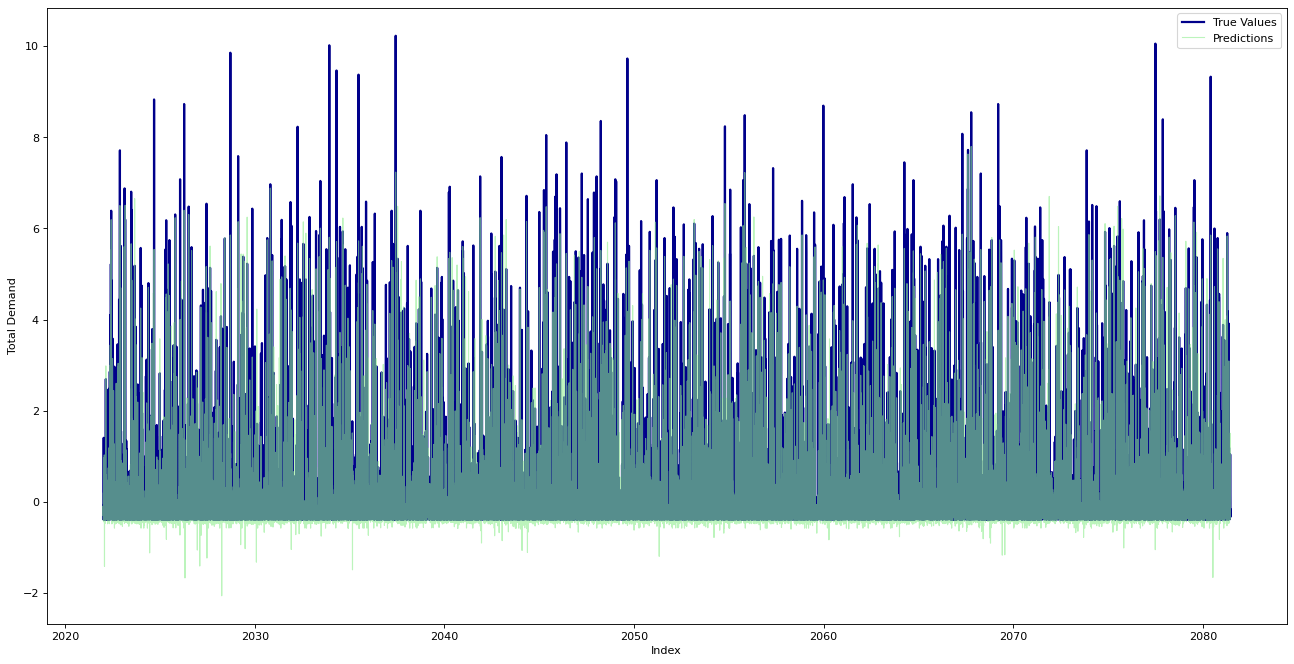

Mean Squared Error: 0.15182948047796926
Root Mean Squared Error: 0.38965302575235994


In [210]:
model_path = 'data/models/model_spatial_8_temporal_1.joblib'
model = load(model_path)

spatial_res = 8
temporal_res = 1

df_plot = create_prediction_dataset(df, temporal_res, spatial_res)
_, _, X_test_scaled, y_test_scaled, _ = split_scale_data(df_plot)

y_pred = model.predict(X_test_scaled)
dates = date_range(start='2022-01-01', periods=len(y_test_scaled), freq='D')
y_test_series = Series(y_test_scaled.flatten(), index=dates)

plot_prediction_vs_reality(y_pred, y_test_series)

### Preliminary conclusion SVM

After a rigorous evaluation phase using only 10% of our dataset, we have identified the most promising models based on their performance metrics and parameter optimization. The selected models for full training are: `res_8_1h`, `res_8_24h`, and `census_24h`. These models showed the best potential in terms of accuracy and robustness during our preliminary assessments.

The results from the scaled-down dataset are as follows:

- **res_8_1h**: Achieved an RMSE of 50.88 and an R² of 0.84.
- **res_8_24h**: Showcased an RMSE of 86.38 with an R² of 0.92.
- **census_1h**:  Achieved an RMSE of 48.75 with an R² of 0.68.
- **census_24h**: Recorded an RMSE of 85.09 and an R² of 0.74.

Although `census_24h` lags slightly behind `res_8_24h`, its lower R² reflects the challenges in modelling accuracy and explainability. This is partly due to the fact that census data is only available for half of the dataset. The project's descriptive analysis shows significant gaps in the availability of census data, particularly in the western regions of the city, which limits the effectiveness of the model in these areas. This uneven distribution of data could lead to under-representation in the model's predictions, affecting its overall accuracy and reliability in reflecting actual demand variations across all regions.

## Neural Network
### Training Approach

As we continue to enhance the predictive capabilities of our models, we employ neural networks due to their exceptional ability to decipher complex spatial and temporal dynamics inherent in our data.

Using the Keras Tuner, we systematically explore a range of hyperparameters to tailor the most effective network architecture for our needs. This exploration includes adjusting the number of hidden layers, the number of units per layer, dropout rates, and regularization techniques to optimize performance and prevent overfitting.

We do this with 15% of the data set. This allows us to quickly evaluate the effectiveness of different configurations without incurring the high computational costs associated with larger datasets. This phase serves as a preliminary filter to identify the most promising model configurations based on their performance metrics.

Once we have determined the optimal configuration through our preliminary tests, we apply this configuration to train models on the entire dataset. This approach ensures that we can exploit the full potential of our data and maximise the accuracy and generalisability of our models.

In [398]:
def build_model(hp):
    model = keras.Sequential()
    # Input
    model.add(layers.Dense(
        units=hp.Int('units_first_layer', min_value=32, max_value=128, step=32),
        activation='relu',
        input_dim=X_train_scaled.shape[1],
        kernel_regularizer=keras.regularizers.l2(
            hp.Float('l2_first_layer', min_value=0.001, max_value=0.01, sampling='LOG'
                     ))
    ))
    model.add(layers.Dropout(hp.Float('dropout_first_layer', min_value=0.1, max_value=0.5, step=0.1)))

    # Hidden Layer
    for i in range(hp.Int('num_hidden_layers', 1, 6)):
        model.add(layers.Dense(units=hp.Int(f'units_layer_{i+1}', min_value=8, max_value=128, step=8),
                               activation='relu', kernel_regularizer=keras.regularizers.l2(hp.Float(f'l2_reg_layer_{i+1}', min_value=0.001, max_value=0.01, sampling='LOG'))))
        model.add(layers.Dropout(hp.Float(f'dropout_layer_{i+1}', min_value=0.1, max_value=0.5, step=0.1)))

    # Output
    model.add(layers.Dense(1, activation='linear'))

    # Optimizer
    if hp.Choice('optimizer', ['adam', 'sgd']) == 'adam':
        optimizer = keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        )
    else:
        optimizer = keras.optimizers.SGD(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'),
            momentum=hp.Float('momentum', min_value=0.0, max_value=0.9)
        )

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [399]:
spatial_res = 8
temporal_res = 1

df_nn = create_prediction_dataset(df, temporal_res, spatial_res)
df_nn_sample = df_nn.sample(frac=0.15)
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler = split_scale_data(df_nn_sample)


Dataset prepared with 
spatial resolution: h3_res_8 
temporal resolution: 1_h



In [400]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=50,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='nn_hyperparam_opt',
    overwrite=True
)

tuner.search(X_train_scaled, y_train_scaled, epochs=20, validation_split=0.2, verbose=1)

Trial 50 Complete [00h 01m 10s]
val_mean_squared_error: 0.13290666043758392

Best val_mean_squared_error So Far: 0.09538448601961136
Total elapsed time: 01h 04m 10s


In [401]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best Hyperparameters:')
print(f'Units in first Layer: {best_hp.get("units_first_layer")}')
print(f'Number of Hidden Layers: {best_hp.get("num_hidden_layers")}')
for i in range(best_hp.get("num_hidden_layers")):
    print(f'Units of Layer {i+1}: {best_hp.get(f"units_layer_{i+1}")}')
print(f'Optimizer: {best_hp.get("optimizer")}')
print(f'Learning Rate: {best_hp.get("learning_rate")}')
if best_hp.get("optimizer") == 'sgd':
    print(f'Momentum: {best_hp.get("momentum")}')

Best Hyperparameters:
Units in first Layer: 64
Number of Hidden Layers: 3
Units of Layer 1: 128
Units of Layer 2: 104
Units of Layer 3: 32
Optimizer: adam
Learning Rate: 0.0008120090241872257


In [402]:
def build_final_model(best_hp):
    model = keras.Sequential()
    # Input
    model.add(layers.Dense(
        units=best_hp.get('units_first_layer'),
        activation='relu',
        input_dim=X_train_scaled.shape[1],
        kernel_regularizer=keras.regularizers.l2(best_hp.get('l2_first_layer'))
    ))
    model.add(layers.Dropout(best_hp.get('dropout_first_layer')))

    # Hidden Layer
    for i in range(best_hp.get('num_hidden_layers')):
        model.add(layers.Dense(
            units=best_hp.get(f'units_layer_{i+1}'),
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(best_hp.get(f'l2_reg_layer_{i+1}'))
        ))
        model.add(layers.Dropout(best_hp.get(f'dropout_layer_{i+1}')))

    # Output
    model.add(layers.Dense(1, activation='linear'))

    if best_hp.get('optimizer') == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=best_hp.get('learning_rate'))
    else:
        optimizer = keras.optimizers.SGD(
            learning_rate=best_hp.get('learning_rate'),
            momentum=best_hp.get('momentum')
        )

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [403]:
def train_model(X_train_scaled, y_train_scaled, best_hp, early_stopping, spatial_unit):
    final_model = build_final_model(best_hp)
    history = final_model.fit(
        X_train_scaled,
        y_train_scaled,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        callbacks=[early_stopping]
    )
    final_model.save(f'data/models/final_model_{spatial_unit}.h5')
    return final_model, history

In [404]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [405]:
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler = split_scale_data(df_nn)

In [406]:
final_model, history = train_model(X_train_scaled, y_train_scaled, best_hp, early_stopping, 'H3')

Epoch 1/100
2715/2715 [==============================] - 11s 3ms/step - loss: 0.5099 - mean_squared_error: 0.2548 - val_loss: 3.4098 - val_mean_squared_error: 3.3119
Epoch 2/100
2715/2715 [==============================] - 9s 3ms/step - loss: 0.1996 - mean_squared_error: 0.1318 - val_loss: 3.1246 - val_mean_squared_error: 3.0719
Epoch 3/100
2715/2715 [==============================] - 9s 3ms/step - loss: 0.1665 - mean_squared_error: 0.1185 - val_loss: 2.3345 - val_mean_squared_error: 2.2905
Epoch 4/100
2715/2715 [==============================] - 9s 3ms/step - loss: 0.1572 - mean_squared_error: 0.1138 - val_loss: 2.4220 - val_mean_squared_error: 2.3794
Epoch 5/100
2715/2715 [==============================] - 9s 3ms/step - loss: 0.1511 - mean_squared_error: 0.1090 - val_loss: 2.1027 - val_mean_squared_error: 2.0610
Epoch 6/100
2715/2715 [==============================] - 9s 3ms/step - loss: 0.1491 - mean_squared_error: 0.1078 - val_loss: 1.9455 - val_mean_squared_error: 1.9042
Epoch 7/1

/Users/mariusbernahrndt/.pyenv/versions/3.10.4/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [407]:
def plot_training_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Progression During Training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

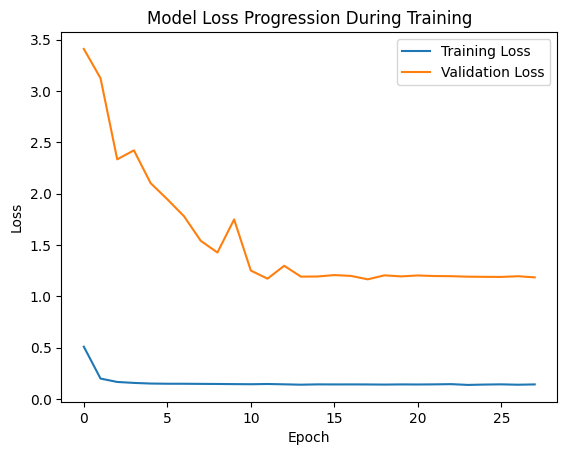

In [408]:
plot_training_history(history)

In [409]:
def evaluate_model(final_model, X_test_scaled, y_test_scaled, scaler):
    test_loss, test_acc = final_model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_acc}')

    y_pred = final_model.predict(X_test_scaled).flatten()
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_rescaled = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    print(f'Metrics for Neural Network:')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2 Score: {r2}')

In [410]:
evaluate_model(final_model, X_test_scaled, y_test_scaled, scaler)

679/679 - 1s - loss: 0.3166 - mean_squared_error: 0.2781 - 1s/epoch - 2ms/step
Test Loss: 0.31660449504852295
Test Accuracy: 0.27813029289245605
679/679 [==============================] - 2s 2ms/step
Metrics for Neural Network:
MSE: 3371.324953943531
RMSE: 58.063111817603534
R2 Score: 0.7218700069078838


### Change from H3 to Census tract

In [416]:
spatial_res = 'census'
temporal_res = 1

df_nn = create_prediction_dataset(df, temporal_res, spatial_res)
df_nn_sample = df_nn.sample(frac=0.15)
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler = split_scale_data(df_nn_sample)


Dataset prepared with 
spatial resolution: census_tract 
temporal resolution: 1_h



In [421]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='nn_hyperparam_opt',
    overwrite=True
)

tuner.search(X_train_scaled, y_train_scaled, epochs=20, validation_split=0.2, verbose=1)

Trial 50 Complete [00h 03m 53s]
val_loss: 3.6684062480926514

Best val_loss So Far: 2.582455635070801
Total elapsed time: 02h 59m 15s


In [422]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler = split_scale_data(df_nn)
final_model, history = train_model(X_train_scaled, y_train_scaled, best_hp, early_stopping, 'Census')

Epoch 1/100
1071/1071 [==============================] - 8s 6ms/step - loss: 1.6661 - mean_squared_error: 0.4465 - val_loss: 3.3117 - val_mean_squared_error: 2.5385
Epoch 2/100
1071/1071 [==============================] - 5s 4ms/step - loss: 0.7509 - mean_squared_error: 0.2036 - val_loss: 3.0604 - val_mean_squared_error: 2.6840
Epoch 3/100
1071/1071 [==============================] - 6s 5ms/step - loss: 0.4232 - mean_squared_error: 0.1469 - val_loss: 3.2492 - val_mean_squared_error: 3.0506
Epoch 4/100
1071/1071 [==============================] - 5s 5ms/step - loss: 0.2825 - mean_squared_error: 0.1277 - val_loss: 3.1732 - val_mean_squared_error: 3.0533
Epoch 5/100
1071/1071 [==============================] - 6s 6ms/step - loss: 0.2172 - mean_squared_error: 0.1173 - val_loss: 3.3966 - val_mean_squared_error: 3.3123
Epoch 6/100
1071/1071 [==============================] - 6s 6ms/step - loss: 0.1826 - mean_squared_error: 0.1082 - val_loss: 3.1601 - val_mean_squared_error: 3.0930
Epoch 7/10

/Users/mariusbernahrndt/.pyenv/versions/3.10.4/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


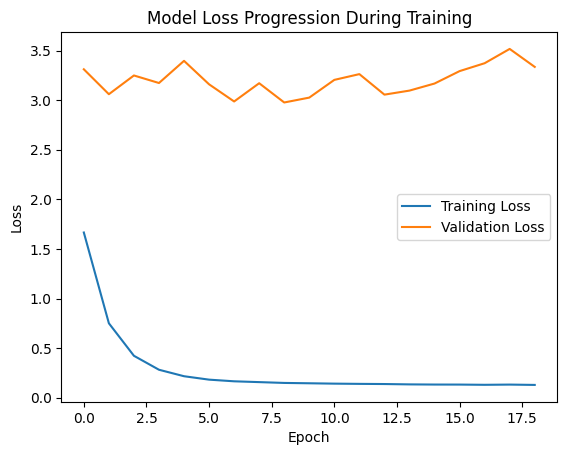

In [423]:
plot_training_history(history)

In [424]:
evaluate_model(final_model, X_test_scaled, y_test_scaled, scaler)

268/268 - 0s - loss: 0.7022 - mean_squared_error: 0.6502 - 389ms/epoch - 1ms/step
Test Loss: 0.7022459506988525
Test Accuracy: 0.6502004265785217
268/268 [==============================] - 1s 2ms/step
Metrics for Neural Network:
MSE: 7143.868944723809
RMSE: 84.52141116145548
R2 Score: 0.3497995495867615


### Preliminary conclusion Neural Network
After the hyperparameter tuning phase with 15% of our dataset, we identified promising neural network configurations. These are specifically tailored to the spatial resolutions `res_8_1h` and `census`.

For the model configuration `res_8_1h`, the mean square error of the model's neural network reached an RMSE of 58.06 and an R² value of 0.72. This performance highlights the model's ability to explain a significant proportion of the variance in the dataset and emphasises its effectiveness.

In contrast, the `census` configuration had an RMSE of 84.52, with a significantly lower R² value of 0.35. Although these figures are less impressive compared to the res_8_1h model, they still provide valuable insights, particularly to illustrate the complexity and impact of using different spatial resolutions on the prediction results.

## Conclusion
In this project, we investigated support vector regression (SVR) and neural networks (NN) for predictive modelling. SVR offers excellent interpretability and stable performance on different dataset sizes, but requires longer training times. In contrast, neural networks offer fast training capabilities and efficiently process large data sets, but require complicated tuning of hyperparameters to prevent overfitting and ensure model reliability.

Despite the fast training benefits of NNs, their setup is complex due to the extensive tuning required, especially given the numerous architectural decisions. SVR, while slower, delivers consistent performance and is less sensitive to the size of the dataset. It is noteworthy that the performance indicators did not change significantly when the amount of data was changed, although the training time increased considerably.

Ultimately, the choice between SVR and NNs should depend on the specific requirements of the project, including considerations of computational resources and data complexity. For our purposes, SVR proves to be the more robust option due to its predictability and lower dependence on dataset variations.

